In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!wget https://www.dropbox.com/s/73uhzn8o7vshhs8/archive.zip?dl=0

In [ ]:
!unzip /content/archive.zip?dl=0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [ ]:
ROOT_DIR="/content/brain_tumor_dataset"
number_of_images = {}
for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))
number_of_images.items()

dict_items([('no', 98), ('yes', 155)])

In [ ]:
def datafolder(p, split):
  if not os.path.exists("./"+p):
    os.mkdir("./"+p)
    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+p+"/"+dir)

      for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR,dir)), 
                                size = (math.floor(split *number_of_images[dir])-5), replace =False):
        O = os.path.join(ROOT_DIR, dir, img)
        D = os.path.join("./"+p,dir)
        shutil.copy(O,D)
        os.remove(O)
  else:
    print("folder exists")


In [ ]:
datafolder("train",0.7)

In [ ]:
datafolder("val", 0.15)

In [ ]:
datafolder("test", 0.15)

In [ ]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras


In [ ]:
model = Sequential()

model.add(Conv2D(filters =16, kernel_size=(3,3), activation="relu", input_shape =(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters =36, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters =64, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters =128, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()


In [ ]:
from keras.backend import binary_crossentropy
model.compile(optimizer = 'adam', loss=keras.losses.binary_crossentropy, metrics =['accuracy'])


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet, preprocess_input

In [ ]:
def preprocessingImages(path):
  image_data = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, preprocessing_function = preprocess_input, horizontal_flip=True)
  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary')
  return image


In [ ]:
path = "/content/train"
train_data = preprocessingImages(path)

Found 166 images belonging to 2 classes.


In [ ]:
train_data.class_indices

{'no': 0, 'yes': 1}

In [ ]:
def preprocessingImages2(path):
  image_data = ImageDataGenerator(preprocessing_function = preprocess_input)
  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary')
  return image

In [ ]:
path ="/content/test"
test_data = preprocessingImages2(path)

Found 27 images belonging to 2 classes.


In [ ]:
path ="/content/val"
val_data = preprocessingImages2(path)

Found 27 images belonging to 2 classes.


In [ ]:
import numpy
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet
import keras


In [ ]:
base_model = MobileNet(input_shape = (224,224,3), include_top =False)

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
X = Flatten()(base_model.output)
x = Dense(units = 1, activation='sigmoid')(X)
model = Model(base_model.input,X)
model.summary

In [ ]:
model.compile(optimizer = 'rmsprop', loss = keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
mc = ModelCheckpoint(filepath="bestmodel.h5", monitor='val_accuracy', verbose=1, save_best_only = True)

In [ ]:
es = EarlyStopping(monitor = 'val_accuracy', min_delta=0.01, patience=3, verbose=1)
cb =[mc,es]

In [ ]:
hist = model.fit_generator(train_data, steps_per_epoch=10, epochs=30, validation_data=val_data, validation_steps=16, 
                           callbacks=cb)

In [ ]:
model = load_model("/content/bestmodel.h5")

In [ ]:
acc = model.evaluate_generator(test_data)[1]
print(f"our model accuracy is {acc*100}%")

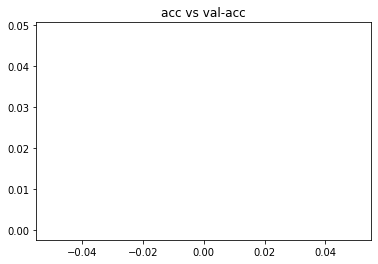

In [ ]:
h = hist.history
h.keys()
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c='red')
plt.title("acc vs val-acc")
plt.show()
##check with diffent data set which have more data.